# Julia is fast

Very often, benchmarks are used to compare languages.  These benchmarks can lead to long discussions, first as to exactly what is being benchmarked and secondly what explains the differences.  These simple questions can sometimes get more complicated than you at first might imagine.

The purpose of this notebook is for you to see a simple benchmark for yourself.  One can read the notebook and see what happened on the author's Macbook Pro with a 4-core Intel Core I7, or run the notebook yourself.

(This material began life as a wonderful lecture by Steven Johnson at MIT: https://github.com/stevengj/18S096/blob/master/lectures/lecture1/Boxes-and-registers.ipynb.)

In [1]:
using Pkg
Pkg.add("BenchmarkTools")
using BenchmarkTools

    Updating registry at `~/.julia/registries/General.toml`


   Resolving package versions...


  No Changes to `~/julia-1.7.3/bin/Project.toml`
  No Changes to `~/julia-1.7.3/bin/Manifest.toml`


# Outline of this notebook

- Define the sum function
- Implementations & benchmarking of sum in...
    - C (hand-written)
    - C (hand-written with -ffast-math)
    - python (built-in)
    - python (numpy)
    - python (hand-written)
    - Julia (built-in)
    - Julia (hand-written)
    - Julia (hand-written with SIMD)
- Summary of benchmarks

# `sum`: An easy enough function to understand

Consider the  **sum** function `sum(a)`, which computes
$$
\mathrm{sum}(a) = \sum_{i=1}^n a_i,
$$
where $n$ is the length of `a`.

In [2]:
a = rand(10^7) # 1D vector of random numbers, uniform on [0,1)

10000000-element Vector{Float64}:
 0.17131188845808898
 0.5763113387433777
 0.8653764021594664
 0.08877155417095872
 0.7611463574346446
 0.622168468697174
 0.8460312397088229
 0.02613244057772801
 0.5426364924172316
 0.5104427351810089
 ⋮
 0.5844960048993394
 0.38096210761593396
 0.2029564183978515
 0.5967249098590003
 0.4484137875129529
 0.8896322049370534
 0.5595681237738765
 0.2906799076796044
 0.6721713135476459

In [3]:
sum(a)

4.999089291305436e6

The expected result is 0.5 * 10^7, since the mean of each entry is 0.5

# Benchmarking a few ways in a few languages

In [4]:
@time sum(a)

  0.005177 seconds (1 allocation: 16 bytes)


4.999089291305436e6

In [5]:
@time sum(a)

  0.006842 seconds (1 allocation: 16 bytes)


4.999089291305436e6

In [6]:
@time sum(a)

  0.007389 seconds (1 allocation: 16 bytes)


4.999089291305436e6

The `@time` macro can yield noisy results, so it's not our best choice for benchmarking!

Luckily, Julia has a `BenchmarkTools.jl` package to make benchmarking easy and accurate:

In [7]:
using Pkg
Pkg.add("BenchmarkTools")

   Resolving package versions...


  No Changes to `~/julia-1.7.3/bin/Project.toml`
  No Changes to `~/julia-1.7.3/bin/Manifest.toml`


In [8]:
using BenchmarkTools  

#  1. The C language

C is often considered the gold standard: difficult on the human, nice for the machine. Getting within a factor of 2 of C is often satisfying. Nonetheless, even within C, there are many kinds of optimizations possible that a naive C writer may or may not get the advantage of.

The current author does not speak C, so he does not read the cell below, but is happy to know that you can put C code in a Julia session, compile it, and run it. Note that the `"""` wrap a multi-line string.

In [9]:
using Libdl
C_code = """
#include <stddef.h>
double c_sum(size_t n, double *X) {
    double s = 0.0;
    for (size_t i = 0; i < n; ++i) {
        s += X[i];
    }
    return s;
}
"""

const Clib = tempname()   # make a temporary file


# compile to a shared library by piping C_code to gcc
# (works only if you have gcc installed):

open(`gcc -fPIC -O3 -msse3 -xc -shared -o $(Clib * "." * Libdl.dlext) -`, "w") do f
    print(f, C_code) 
end

# define a Julia function that calls the C function:
c_sum(X::Array{Float64}) = ccall(("c_sum", Clib), Float64, (Csize_t, Ptr{Float64}), length(X), X)

c_sum (generic function with 1 method)

In [10]:
c_sum(a)

4.999089291304973e6

In [11]:
c_sum(a) ≈ sum(a) # type \approx and then <TAB> to get the ≈ symbolb

true

In [12]:
c_sum(a) - sum(a)

-4.628673195838928e-7

In [13]:
≈  # alias for the `isapprox` function

isapprox (generic function with 9 methods)

We can now benchmark the C code directly from Julia:

In [14]:
c_bench = @benchmark c_sum($a)

BenchmarkTools.Trial: 282 samples with 1 evaluation.
 Range (min … max):  12.687 ms … 40.505 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     17.372 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   17.757 ms ±  2.963 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

         ▂  ▄ ▂ ▄█▂ ▃ ▅▃ ▄▁  ▄▁       ▃                        
  ▃▆▁▆▄▅▆█▆▃█▇█▆███▆█▅█████▆▇██▆▅█▇▆▅▇█▆▆▆▇▄▅▁▄▄▄▁▃▁▃▁▃▁▁▁▃▃▃ ▄
  12.7 ms         Histogram: frequency by time        25.3 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [15]:
println("C: Fastest time was $(minimum(c_bench.times) / 1e6) msec")

C: Fastest time was 12.68685 msec


In [16]:
d = Dict()  # a "dictionary", i.e. an associative array
d["C"] = minimum(c_bench.times) / 1e6  # in milliseconds
d

Dict{Any, Any} with 1 entry:
  "C" => 12.6868

In [17]:
using Plots
gr()

Plots.GRBackend()

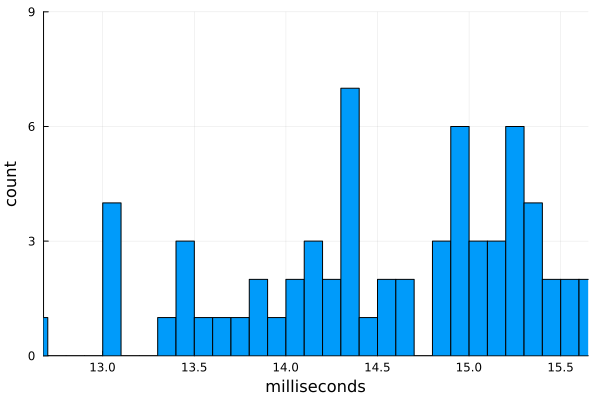

In [18]:
using Statistics # bring in statistical support for standard deviations
t = c_bench.times / 1e6 # times in milliseconds
m, σ = minimum(t), std(t)

histogram(t, bins=500,
    xlim=(m - 0.01, m + σ),
    xlabel="milliseconds", ylabel="count", label="")

# 2. C with -ffast-math

If we allow C to re-arrange the floating point operations, then it'll vectorize with SIMD (single instruction, multiple data) instructions.

In [19]:
const Clib_fastmath = tempname()   # make a temporary file

# The same as above but with a -ffast-math flag added
open(`gcc -fPIC -O3 -msse3 -xc -shared -ffast-math -o $(Clib_fastmath * "." * Libdl.dlext) -`, "w") do f
    print(f, C_code) 
end

# define a Julia function that calls the C function:
c_sum_fastmath(X::Array{Float64}) = ccall(("c_sum", Clib_fastmath), Float64, (Csize_t, Ptr{Float64}), length(X), X)

c_sum_fastmath (generic function with 1 method)

In [20]:
c_fastmath_bench = @benchmark $c_sum_fastmath($a)

BenchmarkTools.Trial: 406 samples with 1 evaluation.
 Range (min … max):   6.491 ms … 21.713 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     12.263 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   12.298 ms ±  2.582 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

           ▂ ▁ ▄ ▄▁▁ ▁▁▃▁▅▅▂▁▁▄ ▃▁▆▁▁▃█▁  ▁                    
  ▃▃▁▁▃▄▃▆▅███▅█▇███▆██████████▇████████▆▇█▅▆▆▆▅▅▆▅▃▃▅▃▁▃▁▁▃▃ ▅
  6.49 ms         Histogram: frequency by time        18.8 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [21]:
d["C -ffast-math"] = minimum(c_fastmath_bench.times) / 1e6  # in milliseconds

6.490781

# 3. Python's built in `sum` 

The `PyCall` package provides a Julia interface to Python:

In [22]:
using Pkg; Pkg.add("PyCall")
using PyCall

   Resolving package versions...


  No Changes to `~/julia-1.7.3/bin/Project.toml`
  No Changes to `~/julia-1.7.3/bin/Manifest.toml`


In [23]:
# get the Python built-in "sum" function:
pysum = pybuiltin("sum")

PyObject <built-in function sum>

In [24]:
pysum(a)

4.999089291304973e6

In [25]:
pysum(a) ≈ sum(a)

true

In [26]:
py_list_bench = @benchmark $pysum($a)

BenchmarkTools.Trial: 5 samples with 1 evaluation.
 Range (min … max):  1.037 s …   1.270 s  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     1.194 s              ┊ GC (median):    0.00%
 Time  (mean ± σ):   1.174 s ± 96.000 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █                   █                 █            █    █  
  █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁█ ▁
  1.04 s         Histogram: frequency by time        1.27 s <

 Memory estimate: 288 bytes, allocs estimate: 9.

In [27]:
d["Python built-in"] = minimum(py_list_bench.times) / 1e6
d

Dict{Any, Any} with 3 entries:
  "C"               => 12.6868
  "Python built-in" => 1037.42
  "C -ffast-math"   => 6.49078

# 4. Python: `numpy` 

## Takes advantage of hardware "SIMD", but only works when it works.

`numpy` is an optimized C library, callable from Python.
It may be installed within Julia as follows:

In [28]:
using Pkg; Pkg.add("Conda")
using Conda

   Resolving package versions...


  No Changes to `~/julia-1.7.3/bin/Project.toml`
  No Changes to `~/julia-1.7.3/bin/Manifest.toml`


In [29]:
Conda.add("numpy")

┌ Info: Running `conda install -y numpy` in root environment
└ @ Conda /home/tbushnell/.julia/packages/Conda/2lg2O/src/Conda.jl:127


done
Solving environment: ...working... 

done

# All requested packages already installed.



In [30]:
numpy_sum = pyimport("numpy")["sum"]

py_numpy_bench = @benchmark $numpy_sum($a)

BenchmarkTools.Trial: 807 samples with 1 evaluation.
 Range (min … max):  4.117 ms … 12.259 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     5.642 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   6.179 ms ±  1.718 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

   ▁▄█▆▁▁▁ ▁  ▁                                               
  ▃██████████▆█▄▇▇▆█▅▅▆▅▇▄▅▅▅▄▄▄▄▃▃▃▄▃▄▃▄▄▄▄▄▃▃▃▄▂▃▃▂▂▃▂▂▁▂▂ ▄
  4.12 ms        Histogram: frequency by time        11.2 ms <

 Memory estimate: 288 bytes, allocs estimate: 9.

In [31]:
numpy_sum(a)

4.9990892913054405e6

In [32]:
numpy_sum(a) ≈ sum(a)

true

In [33]:
d["Python numpy"] = minimum(py_numpy_bench.times) / 1e6
d

Dict{Any, Any} with 4 entries:
  "C"               => 12.6868
  "Python numpy"    => 4.11665
  "Python built-in" => 1037.42
  "C -ffast-math"   => 6.49078

# 5. Python, hand-written 

In [34]:
py"""
def py_sum(A):
    s = 0.0
    for a in A:
        s += a
    return s
"""

sum_py = py"py_sum"

PyObject <function py_sum at 0x7f3c3a4d3430>

In [35]:
py_hand = @benchmark $sum_py($a)

BenchmarkTools.Trial: 7 samples with 1 evaluation.
 Range (min … max):  772.096 ms … 849.037 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     817.612 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   808.131 ms ±  31.175 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █   ██                              █        ██             █  
  █▁▁▁██▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁██▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  772 ms           Histogram: frequency by time          849 ms <

 Memory estimate: 288 bytes, allocs estimate: 9.

In [36]:
sum_py(a)

4.999089291304973e6

In [37]:
sum_py(a) ≈ sum(a)

true

In [38]:
d["Python hand-written"] = minimum(py_hand.times) / 1e6
d

Dict{Any, Any} with 5 entries:
  "C"                   => 12.6868
  "Python numpy"        => 4.11665
  "Python hand-written" => 772.096
  "Python built-in"     => 1037.42
  "C -ffast-math"       => 6.49078

# 6. Julia (built-in) 

## Written directly in Julia, not in C!

In [39]:
@which sum(a)

sum(a::AbstractArray; dims, kw...) in Base at reducedim.jl:889

In [40]:
j_bench = @benchmark sum($a)

BenchmarkTools.Trial: 600 samples with 1 evaluation.
 Range (min … max):  5.934 ms … 11.748 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     8.098 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   8.313 ms ±  1.301 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

         █▄▅   ▂▂ ▁   ▂    ▂                                  
  ▂▂▁▁▂▃▅███▆▆██████▆█████▅██▆▆▆▇██▆▅▆▆▆▅▆▄▅▄▆█▆▄▄▃▃▄▄▅▄▃▄▂▃ ▄
  5.93 ms        Histogram: frequency by time        11.4 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [41]:
d["Julia built-in"] = minimum(j_bench.times) / 1e6
d

Dict{Any, Any} with 6 entries:
  "C"                   => 12.6868
  "Python numpy"        => 4.11665
  "Python hand-written" => 772.096
  "Python built-in"     => 1037.42
  "Julia built-in"      => 5.93377
  "C -ffast-math"       => 6.49078

# 7. Julia (hand-written) 

In [42]:
function mysum(A)   
    s = 0.0 # s = zero(eltype(a))
    for a in A
        s += a
    end
    s
end

mysum (generic function with 1 method)

In [43]:
j_bench_hand = @benchmark mysum($a)

BenchmarkTools.Trial: 355 samples with 1 evaluation.
 Range (min … max):  10.967 ms … 24.038 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     13.792 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   14.077 ms ±  1.916 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

        ▂▁ ▂█▁▂ ▁ ▂▄ ▁▃▂ ▂▂  ▂   ▂                             
  ▃▄▅▆▆█████████████████▇██▇███▅▆██▆▄▆▃▅▃▁▅▄▃▄▃▁▁▃▁▁▃▃▃▁▃▃▃▃▃ ▄
  11 ms           Histogram: frequency by time        19.6 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [44]:
d["Julia hand-written"] = minimum(j_bench_hand.times) / 1e6
d

Dict{Any, Any} with 7 entries:
  "C"                   => 12.6868
  "Python numpy"        => 4.11665
  "Julia hand-written"  => 10.9671
  "Python hand-written" => 772.096
  "Python built-in"     => 1037.42
  "Julia built-in"      => 5.93377
  "C -ffast-math"       => 6.49078

# 8. Julia (hand-written w. simd) 

In [45]:
function mysum_simd(A)   
    s = 0.0 # s = zero(eltype(A))
    @simd for a in A
        s += a
    end
    s
end

mysum_simd (generic function with 1 method)

In [46]:
j_bench_hand_simd = @benchmark mysum_simd($a)

BenchmarkTools.Trial: 630 samples with 1 evaluation.
 Range (min … max):  6.253 ms … 11.864 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     7.644 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   7.909 ms ±  1.218 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

     █▆▂▂▄ ▂▁      ▁                                          
  ▂▃▅████████▇▇▆█▆▅███▇▇▇▇▇▃▅▅▂▄▃▃▅▅▃▄▄▂▃▅▄▃▃▃▂▃▅▃▄▃▄▃▂▃▅▁▂▃ ▃
  6.25 ms        Histogram: frequency by time        10.8 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [47]:
mysum_simd(a)

4.999089291305397e6

In [48]:
d["Julia hand-written simd"] = minimum(j_bench_hand_simd.times) / 1e6
d

Dict{Any, Any} with 8 entries:
  "Julia hand-written simd" => 6.25278
  "C"                       => 12.6868
  "Python numpy"            => 4.11665
  "Julia hand-written"      => 10.9671
  "Python hand-written"     => 772.096
  "Python built-in"         => 1037.42
  "Julia built-in"          => 5.93377
  "C -ffast-math"           => 6.49078

# Summary

In [49]:
for (key, value) in sort(collect(d), by=last)
    println(rpad(key, 25, "."), lpad(round(value; digits=1), 6, "."))
end

Python numpy................4.1
Julia built-in..............5.9
Julia hand-written simd.....6.3
C -ffast-math...............6.5
Julia hand-written.........11.0
C..........................12.7
Python hand-written.......772.1
Python built-in..........1037.4
